In [1]:
import pandas as pd

In [ ]:
data=pd.read_excel('Data/train_data.xlsx')
data=pd.concat([data,pd.read_excel('Data/test_data.xlsx')],ignore_index=True)


AttributeError: module 'pandas' has no attribute 'hist'

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day_of_month'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>, <Axes: >, <Axes: >]],
      dtype=object)

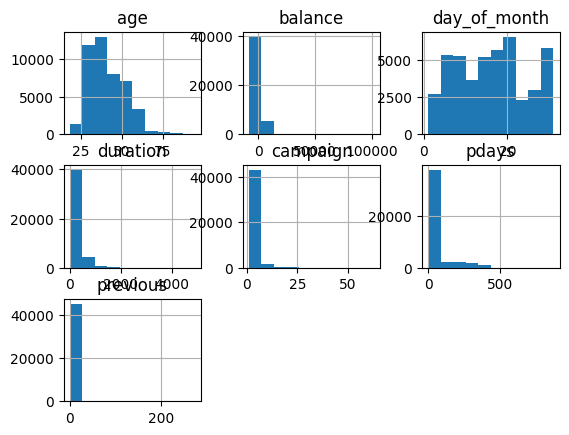

In [7]:
data.hist()

In [9]:
"""
plotly_plots_for_dataset.py

- Loads Excel dataset at /mnt/data/test_data.xlsx
- Creates Plotly interactive histograms for numeric covariates
- Creates Plotly stacked bar charts (category vs y) if y is present (yes/no)
- Saves each chart as an HTML file into ./plots_plotly/

Usage:
    python plotly_plots_for_dataset.py
"""

import os
import pandas as pd
import plotly.express as px

# === CONFIG ===
NBINS = 30   # number of histogram bins


# === Load data ===
# If your file has multiple sheets you can pass sheet_name="Sheet1" etc.
df = data

# === Detect target column (case-insensitive common names) ===
target = None
for cand in ["y", "target", "label"]:
    if cand in map(str.lower, df.columns):
        # get actual column name with original casing
        for c in df.columns:
            if c.lower() == cand:
                target = c
                break
        if target:
            break

# if not found, leave target as None
print("Detected target column:", target)

# === Identify numeric and categorical columns ===
numeric_cols = df.select_dtypes(include="number").columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Remove the target from categorical list if present
if target in cat_cols:
    cat_cols = [c for c in cat_cols if c != target]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)

# === Helper to save interactive fig ===
"""def save_fig(fig, name):
    out_path = os.path.join(OUT_DIR, name)
    fig.write_html(out_path, include_plotlyjs="cdn")
    print("Saved:", out_path)"""

# === 1) Histograms for numeric covariates ===
for col in numeric_cols:
    # Create histogram with a marginal box to show spread (optional)
    fig = px.histogram(df, x=col, nbins=NBINS,
                       title=f"Histogram of {col}",
                       marginal="box", # remove or change to 'rug' / None if you dislike box
                       labels={col: col})
    fig.update_layout(template="simple_white", bargap=0.05)
    # Save HTML
    safe_name = f"hist_{col}.html".replace(" ", "_")
    fig.show()
    #save_fig(fig, safe_name)

# === 2) Stacked bar charts for categorical covariates vs yes/no ===
# Only make stacked bars if we detected a binary yes/no-like target
make_stacked = False
if target is not None:
    # normalize target values to lower-case strings for checking
    unique_vals = {str(v).strip().lower() for v in df[target].dropna().unique()}
    if unique_vals <= {"yes", "no"} or unique_vals <= {"y", "n"}:
        make_stacked = True

if make_stacked:
    print("Creating stacked bar charts vs", target)
    for col in cat_cols:
        # Build a tidy DataFrame for plotting stacked bars:
        ct = pd.crosstab(df[col].fillna("Missing"), df[target])
        # ensure consistent order yes/no if present
        possible_order = ["no", "yes", "n", "y"]
        cols_ordered = [c for c in possible_order if c in map(str.lower, ct.columns)]
        if not cols_ordered:
            cols_ordered = ct.columns.tolist()

        # Reindex columns in original casing order
        # We'll melt ct to long form
        ct_reset = ct.reset_index().melt(id_vars=col, var_name=target, value_name="count")
        # If melt changed types (e.g., booleans), make sure target values are strings for color
        ct_reset[target] = ct_reset[target].astype(str)

        fig = px.bar(ct_reset, x=col, y="count", color=target, title=f"{col} vs {target} (stacked)",
                     labels={col: col, "count": "Count", target: target},
                     barmode="stack", text="count")
        fig.update_traces(texttemplate='%{text}', textposition='inside')
        fig.update_layout(xaxis_tickangle=-45, template="simple_white")
        safe_name = f"stacked_{col}_vs_{target}.html".replace(" ", "_")
        fig.show()
        #save_fig(fig, safe_name)
else:
    print("No yes/no target detected — skipping stacked bar charts.")

#print("All done. Open the HTML files in the folder:", os.path.abspath(OUT_DIR))

Detected target column: y
Numeric columns: ['age', 'balance', 'day_of_month', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


Creating stacked bar charts vs y


In [10]:
"""
stacked_bars_all_vars.py

- Loads: /mnt/data/test_data.xlsx
- For categorical columns: stacked bar (levels vs yes/no)
- For numeric columns: bins -> then stacked bar (bin ranges vs yes/no)
- Produces a single Plotly figure with subplots (2 columns by default)
- Saves HTML to plots_plotly/stacked_all_vars.html
"""

import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ---- CONFIG ----
#DATA_PATH = "/mnt/data/test_data.xlsx"   # uploaded file
OUT_DIR = "plots_plotly"
OUT_FILE = os.path.join(OUT_DIR, "stacked_all_vars.html")
os.makedirs(OUT_DIR, exist_ok=True)

# Binning options for numeric columns:
BIN_METHOD = "quantile"   # "quantile" or "uniform"
NBINS = 10                # number of bins

# Subplot grid
N_COLS = 2

# ---- Load data ----
df =data

# ---- Detect binary target (y / yes-no) ----
target = None
for cand in ["y", "target", "label"]:
    for c in df.columns:
        if c.lower() == cand:
            target = c
            break
    if target:
        break

if target is None:
    raise ValueError("No target column detected (expected 'y' or similar).")

# normalize target values to 'yes'/'no'
def normalize_target(v):
    s = str(v).strip().lower()
    if s in {"y", "yes"}:
        return "yes"
    if s in {"n", "no"}:
        return "no"
    return s

df[target] = df[target].apply(normalize_target)
unique_vals = set(df[target].dropna().unique())
if not (unique_vals <= {"yes", "no"}):
    raise ValueError(f"Target column {target} isn't binary yes/no after normalization. Found: {unique_vals}")

# ---- Identify categorical and numeric columns ----
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
# remove target from cat_cols if present
cat_cols = [c for c in cat_cols if c != target]

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# We'll build a list of "variables to plot" where for numeric ones we'll make a binned column name
plot_vars = []  # list of tuples: (display_name, series_values)
# Add categorical cols as-is
for c in cat_cols:
    series = df[c].fillna("Missing").astype(str)
    plot_vars.append((c, series))

# Add numeric cols as binned series
for c in num_cols:
    colvals = df[c]
    # handle empty / all NaN
    if colvals.dropna().empty:
        continue
    if BIN_METHOD == "quantile":
        try:
            binned, bins = pd.qcut(colvals, q=NBINS, duplicates="drop", retbins=True)
            binned = binned.astype(str).fillna("Missing")
        except Exception:
            # fall back to uniform if qcut fails
            binned = pd.cut(colvals, bins=NBINS).astype(str).fillna("Missing")
    else:  # uniform
        binned = pd.cut(colvals, bins=NBINS).astype(str).fillna("Missing")
    # optional: prefix numeric col name so it's clear it's binned
    display_name = f"{c} (binned)"
    plot_vars.append((display_name, binned))

if not plot_vars:
    raise ValueError("No variables found to plot.")

# ---- Prepare subplot grid ----
n = len(plot_vars)
rows = (n + N_COLS - 1) // N_COLS

fig = make_subplots(rows=rows, cols=N_COLS, subplot_titles=[pv[0] for pv in plot_vars],
                    horizontal_spacing=0.09, vertical_spacing=0.12)

# Keep track of legend shown (only once)
legend_shown = set()

# Add one subplot per variable
for i, (name, series) in enumerate(plot_vars):
    row = i // N_COLS + 1
    col = i % N_COLS + 1

    # Build crosstab of levels vs yes/no
    # Align index order by frequency descending (so big bars left)
    ct = pd.crosstab(series, df[target]).astype(int)
    # Ensure columns 'no' and 'yes' exist
    for k in ["no", "yes"]:
        if k not in ct.columns:
            ct[k] = 0
    # Order by total frequency descending
    ct["__total__"] = ct.sum(axis=1)
    ct = ct.sort_values("__total__", ascending=False).drop(columns="__total__")
    x = ct.index.tolist()

    # Add stacked traces: 'no' first, then 'yes' on top
    for tgt in ["no", "yes"]:
        showleg = False
        if tgt not in legend_shown:
            showleg = True
            legend_shown.add(tgt)
        fig.add_trace(
            go.Bar(x=x, y=ct[tgt].values, name=tgt, showlegend=showleg, text=ct[tgt].values, textposition="inside"),
            row=row, col=col
        )

    # improve axis readability
    fig.update_xaxes(tickangle=-45, row=row, col=col)
    # reduce tick label font size if many categories
    if len(x) > 12:
        fig.update_xaxes(tickfont=dict(size=9), row=row, col=col)

# Layout
fig.update_layout(height=350*rows, width=1200, title_text="Stacked counts (no / yes) for categorical + binned numeric variables",
                  barmode="stack", template="simple_white")

# Save HTML
fig.write_html(OUT_FILE, include_plotlyjs="cdn")
print("Saved combined stacked plot to:", OUT_FILE)

Saved combined stacked plot to: plots_plotly/stacked_all_vars.html


In [22]:
"""
stacked_individual_plots_clean.py

- Loads /mnt/data/test_data.xlsx
- For each categorical column: stacked bar (levels vs yes/no)
- For each numeric column: bin into NBINS, convert bins to clean class marks (midpoints)
  and create stacked bar (class mark vs yes/no)
- Saves each plot as an interactive Plotly HTML file under plots_plotly/individual/

Usage:
    python stacked_individual_plots_clean.py
"""

import os
import re
import pandas as pd
import numpy as np
import plotly.express as px

# ---------- CONFIG ----------
DATA_PATH = "/mnt/data/test_data.xlsx"   # path to your uploaded file
OUT_DIR = "plots_plotly/individual"      # output folder for individual HTMLs
os.makedirs(OUT_DIR, exist_ok=True)

NBINS = 10               # number of bins for numeric variables
BIN_METHOD = "quantile"  # "quantile" or "uniform"
TARGET_CANDIDATES = ["y", "target", "label"]  # names to search for target column

# Choose label style for numeric bins: "midpoint" or "range"
CLASS_LABEL_STYLE = "midpoint"  # "midpoint" -> 12.34 ; "range" -> "10 - 20"

# ---------- HELPERS ----------
def normalize_target_value(v):
    """Normalize target to 'yes'/'no' strings (lowercase)."""
    if pd.isna(v):
        return v
    s = str(v).strip().lower()
    if s in {"y", "yes"}:
        return "yes"
    if s in {"n", "no"}:
        return "no"
    return s

def safe_binning(series, method="quantile", nbins=10):
    """
    Bin a numeric series robustly.
    Returns a pandas.Series of Interval objects or 'Missing' for NaNs.
    """
    if series.dropna().empty:
        # everything missing
        return pd.Series(["Missing"] * len(series), index=series.index, dtype="object")

    try:
        if method == "quantile":
            binned = pd.qcut(series, q=nbins, duplicates="drop")
        else:
            binned = pd.cut(series, bins=nbins)
    except Exception:
        # fallback to uniform bins if qcut fails
        binned = pd.cut(series, bins=nbins)
    # Keep NA as "Missing"
    binned = binned.astype(object).where(~series.isna(), other="Missing")
    return binned

def interval_to_midpoint_label(iv):
    """Given a pandas.Interval or string like '(a, b]' produce a rounded midpoint string."""
    if isinstance(iv, str):
        if iv == "Missing":
            return "Missing"
        # try to extract numbers
        nums = re.findall(r"[-+]?\d*\.\d+|\d+", iv)
        if len(nums) >= 2:
            a, b = float(nums[0]), float(nums[1])
            return f"{round((a+b)/2, 2)}"
        return iv
    # pandas.Interval
    try:
        a = float(iv.left)
        b = float(iv.right)
        return f"{round((a+b)/2, 2)}"
    except Exception:
        return str(iv)

def interval_to_range_label(iv):
    """Return a human-friendly range string 'a - b' without long decimals."""
    if isinstance(iv, str):
        return iv
    try:
        a = float(iv.left)
        b = float(iv.right)
        # choose formatting: if ints then no decimals, else 2 decimals
        if (a).is_integer() and (b).is_integer():
            return f"{int(a)} - {int(b)}"
        return f"{round(a,2)} - {round(b,2)}"
    except Exception:
        return str(iv)

def save_plot(fig, filename):
    """Save Plotly figure to HTML file inside OUT_DIR and return the path."""
    out_path = os.path.join(OUT_DIR, filename)
    fig.write_image(out_path)
    print("Saved:", out_path)
    return out_path

# ---------- LOAD DATA ----------
df = data
print(f"Loaded {DATA_PATH} (rows: {len(df)}, cols: {len(df.columns)})")

# ---------- FIND TARGET ----------
target = None
for cand in TARGET_CANDIDATES:
    for c in df.columns:
        if c.lower() == cand:
            target = c
            break
    if target:
        break

if target is None:
    raise ValueError(f"No target column found. Expected one of {TARGET_CANDIDATES} (case-insensitive).")

# normalize target values
df[target] = df[target].apply(normalize_target_value)

unique_targets = sorted(df[target].dropna().unique())
if set(unique_targets) - {"yes", "no"}:
    raise ValueError(f"Target column '{target}' does not look like a binary yes/no. Values found: {unique_targets}")

print("Detected binary target:", target, "values:", unique_targets)

# ---------- IDENTIFY COLUMNS ----------
cat_cols = [c for c in df.select_dtypes(include=["object", "category", "bool"]).columns if c != target]
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# ---------- PLOTTING: CATEGORICAL ----------
saved_files = []
for col in cat_cols:
    series = df[col].fillna("Missing").astype(str)
    ct = pd.crosstab(series, df[target])
    # ensure both no/yes columns exist
    for k in ["no", "yes"]:
        if k not in ct.columns:
            ct[k] = 0
    # order categories by total frequency desc
    ct["__total__"] = ct.sum(axis=1)
    ct = ct.sort_values("__total__", ascending=False).drop(columns="__total__")
    ct = ct[["no", "yes"]]

    ct_long = ct.reset_index().melt(id_vars=col, var_name=target, value_name="count")
    order = ct.sum(axis=1).sort_values(ascending=False).index.tolist()

    fig = px.bar(ct_long, x=col, y="count", color=target,
                 category_orders={col: order, target: ["no", "yes"]},
                 title=f"{str.capitalize(col)}", barmode="stack", text="count",
                 labels={col: col, "count": "Count", target: target})
    fig.update_traces(texttemplate="%{text}", textposition="inside")
    fig.update_layout(template="simple_white", xaxis_tickangle=-45, yaxis_title="Count")
    fname = f"{col}_vs_{target}.png".replace(" ", "_")
    saved_files.append(save_plot(fig, fname))

# ---------- PLOTTING: NUMERIC (BIN -> CLASS MARK) ----------
for col in num_cols:
    binned = safe_binning(df[col], method=BIN_METHOD, nbins=NBINS)

    # Build labels using chosen style
    if CLASS_LABEL_STYLE == "midpoint":
        labels = [interval_to_midpoint_label(iv) for iv in binned]
    else:
        labels = [interval_to_range_label(iv) for iv in binned]

    label_col = f"{col}"
    df[label_col] = labels

    ct = pd.crosstab(df[label_col], df[target]).astype(int)
    for k in ["no", "yes"]:
        if k not in ct.columns:
            ct[k] = 0

    # Try to order bins numerically by midpoint where possible
    def parse_label_to_sort_key(lbl):
        if lbl == "Missing":
            return float("inf")  # put Missing at the end
        # try parse numeric midpoint
        try:
            # midpoint style is numeric string
            val = float(lbl)
            return val
        except Exception:
            # range style 'a - b' -> take left bound
            m = re.match(r"\s*([-+]?\d*\.?\d+)", lbl)
            if m:
                return float(m.group(1))
            return lbl  # fallback lexicographic

    order = sorted(ct.index.tolist(), key=parse_label_to_sort_key)
    ct = ct.reindex(order)

    ct_long = ct.reset_index().melt(id_vars=label_col, var_name=target, value_name="count")

    # If too many bins, rotate labels and reduce font
    tickangle = -45 if len(order) > 6 else -15
    tickfont = dict(size=10) if len(order) > 12 else None

    fig = px.bar(ct_long, x=label_col, y="count", color=target,
                 category_orders={label_col: order, target: ["no", "yes"]},
                 title=f"{str.capitalize(col)}", barmode="stack", text="count",
                 labels={label_col: f"{col}", "count": "Count", target: target})
    fig.update_traces(texttemplate="%{text}", textposition="inside")
    fig.update_layout(template="simple_white", xaxis_tickangle=tickangle, yaxis_title="Count")
    if tickfont:
        fig.update_xaxes(tickfont=tickfont)

    fname = f"{col}_binned_vs_{target}.png".replace(" ", "_")
    saved_files.append(save_plot(fig, fname))

# ---------- FINISH ----------
print("\nGenerated plots:")
for p in saved_files:
    print(" -", os.path.abspath(p))

print("\nOpen the HTML files in the folder:", os.path.abspath(OUT_DIR))

Loaded /mnt/data/test_data.xlsx (rows: 45211, cols: 24)
Detected binary target: y values: ['no', 'yes']
Categorical columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_month', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'age_binned_label', 'balance_binned_label', 'day_of_month_binned_label', 'duration_binned_label', 'campaign_binned_label', 'pdays_binned_label', 'previous_binned_label']
Numeric columns: []
Saved: plots_plotly/individual/age_vs_y.png
Saved: plots_plotly/individual/job_vs_y.png
Saved: plots_plotly/individual/marital_vs_y.png
Saved: plots_plotly/individual/education_vs_y.png
Saved: plots_plotly/individual/default_vs_y.png
Saved: plots_plotly/individual/balance_vs_y.png
Saved: plots_plotly/individual/housing_vs_y.png
Saved: plots_plotly/individual/loan_vs_y.png
Saved: plots_plotly/individual/contact_vs_y.png
Saved: plots_plotly/individual/day_of_month_vs_y.png
Saved: plots_plotly/individual/month

In [20]:
import pandas as pd
import plotly.express as px

# Load your dataset
df = data

# Detect target column
target = None
for cand in ["y", "target", "label"]:
    for c in df.columns:
        if c.lower() == cand:
            target = c
            break
    if target:
        break

if target is None:
    raise ValueError("No target column found (expected y/target/label).")

# Normalize yes/no
def normalize_target(v):
    if pd.isna(v):
        return v
    s = str(v).strip().lower()
    if s in {"yes", "y"}:
        return "yes"
    if s in {"no", "n"}:
        return "no"
    return s

df[target] = df[target].apply(normalize_target)

# Count distribution
counts = df[target].value_counts().reset_index()
counts.columns = [target, "count"]

# Plot thinner bars + taller figure
fig = px.bar(
    counts,
    x=target,
    y="count",
    text="count",
    color=target,
    title="Distribution of Target Variable (yes/no)",
    labels={target: "Target", "count": "Count"},
)

# Make bars thinner
fig.update_traces(width=0.4, textposition="outside")

# Increase height
fig.update_layout(
    template="simple_white",
    height=700,   # adjust as you like (700–900 looks great)
)

fig.show()

In [ ]:
fig.